<a href="https://colab.research.google.com/github/TheVhd/rags/blob/main/LangChainDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install jq

In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

In [ ]:
pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("/content/HighSchool_bio.pdf")
pages = loader.load_and_split()

In [ ]:
pages[15]

Document(page_content='Glycolysis means ‘splitting of sugar’. It takes place in all organisms, in the cytoplasm of the\ncell. It is the first stage of respiration—both aerobic and anaerobic. After glycolysis, its product\n(pyruvate) gets converted into different compou nds depending on whether further reactions take\nplace in the presence or absence of oxygen.\nGlycolysis is the last energy-producing stage in case oxygen is absent or in low supply, and in\ncells that lack mitochondria. After glycolysis, further anaerobic reactions produce differentproducts like lactic acid orethanol (ethyl alcohol) in different situations. This step completes the\nanaerobic \nrespiration of glucose. Anaerobic r espiration resulting in the formation of these\nproducts is also called fermentation. Examples of lactic acid fermentation and alcohol\nfermenta\ntion are given below.\nIn a low supply of oxygen, yeast converts pyruvate to ethanol and carbon dioxide. Certain\nbacteria (which lack mitochondria) c

## Environment settings

In [ ]:
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')

In [ ]:
from google.colab import userdata
langsmith_api_key = userdata.get('langsmith')

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = langsmith_api_key

In [ ]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(pages)

# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=OpenAIEmbeddings(api_key = openai_api_key))

retriever = vectorstore.as_retriever()

In [ ]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives
    | ChatOpenAI(api_key = openai_api_key, temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [ ]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is Glycolysis?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


11

In [ ]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(api_key = openai_api_key, temperature=0)

final_rag_chain = (
    {"context": retrieval_chain,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Glycolysis is the process of splitting sugar and it takes place in all organisms, in the cytoplasm of the cell. It is the first stage of respiration, both aerobic and anaerobic. After glycolysis, its product (pyruvate) gets converted into different compounds depending on whether further reactions take place in the presence or absence of oxygen.'

## RAG-Fusion

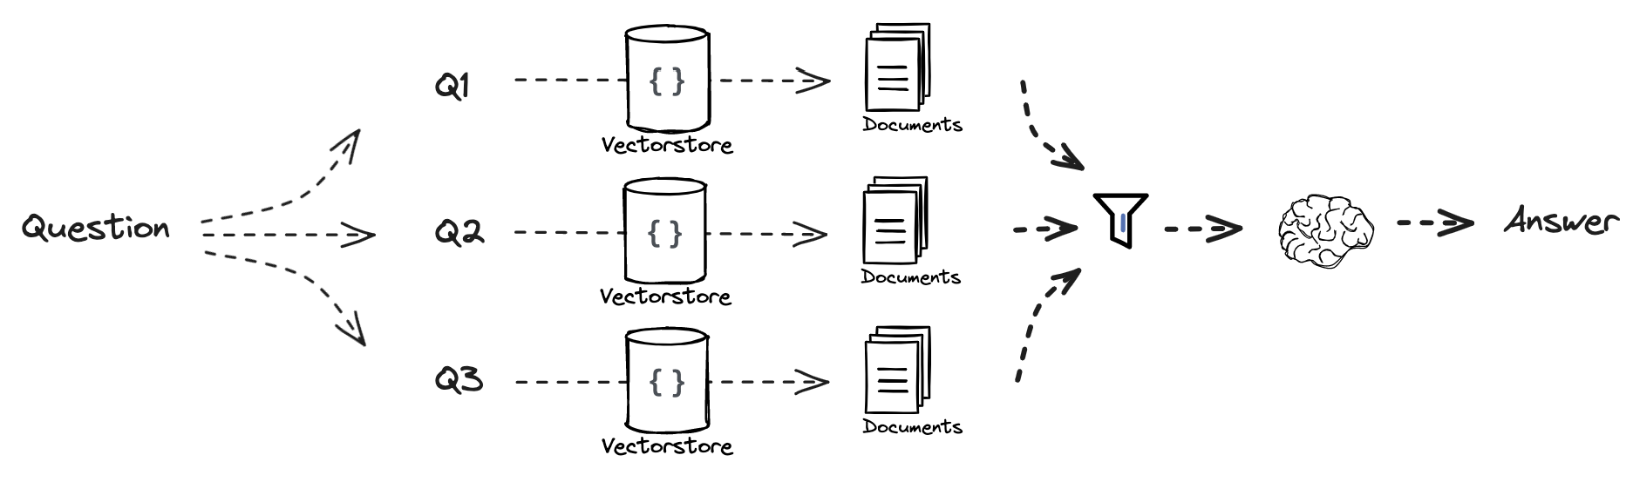

##Testing with unstructured Data Loader

In [ ]:
pip install unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 8.7 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=5a3af70cc3e9b719f94b193e938908c1d983ebd375d38a50a0f6e55287399db2
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
pip install pdf2image

In [ ]:
#pip install pdfminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.5 MB/s eta 0:00:00
  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140123 sha256=dcd8d3499e466199f6c9394c51c667de082bca0c7024a4bfc8d643a7be67d08c
  Stored in directory: /root/.cache/pip/wheels/4e/c1/68/f7bd0a8f514661f76b5cbe3b5f76e0033d79f1296012cbbf72
Successfully built pdfminer


In [ ]:
pip install pdfminer.six

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 63.2 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 3.4.8
    Uninstalling cryptography-3.4.8:
      Successfully uninstalled cryptography-3.4.8


In [ ]:
pip install --upgrade pdfminer.six

In [ ]:
pip uninstall pdfminer.six

In [ ]:
pip uninstall pdfminer

Found existing installation: pdfminer 20191125
Uninstalling pdfminer-20191125:
  Would remove:
    /usr/local/bin/dumppdf.py
    /usr/local/bin/pdf2txt.py
    /usr/local/lib/python3.10/dist-packages/pdfminer-20191125.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pdfminer/*
Proceed (Y/n)? y
  Successfully uninstalled pdfminer-20191125


In [ ]:
pip install pillow-heif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 21.4 MB/s eta 0:00:00


In [ ]:
pip install pikepdf

In [ ]:
pip install unstructured_inference

In [ ]:
pip install pytesseract

In [ ]:
pip install --upgrade pdf2image

In [ ]:
from langchain_community.document_loaders import UnstructuredPDFLoader

In [ ]:
loader = UnstructuredPDFLoader("/content/HighSchool_bio.pdf")

In [ ]:
data2 = loader.load()

KeyError: '8496a0a297ef80f2b195ca8a28b4e60f'

In [ ]:
data1[17]

NameError: name 'data1' is not defined

## JSON Loader

In [ ]:
import os

langsmth_api_key = "ls__67641b5f75964b90b9bedc147d816272"
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = langsmth_api_key

In [ ]:
import json
from pathlib import Path
from pprint import pprint


file_path='/content/HighSchool_bio_data.json'
data = json.loads(Path(file_path).read_text())

In [ ]:
pprint(data)

[Document(page_content='', metadata={'source': '/content/HighSchool_bio_data.json', 'seq_num': 1})]


In [ ]:
from langchain_community.document_loaders import JSONLoader


loader = JSONLoader(
    file_path='/content/HighSchool_bio_data.json',
    jq_schema='.page',
    text_content=True,
    json_lines=False)

data = loader.load()

In [ ]:
pprint(data)

[Document(page_content='', metadata={'source': '/content/HighSchool_bio_data.json', 'seq_num': 1})]


In [ ]:
import json

with open('/content/HighSchool_bio_data.json', 'r') as f:
    data = json.load(f)
    print(json.dumps(data, indent=4))